In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import date2num

In [2]:
trades_path = "../data/trade_data_2024_04_01.csv"
quotes_path = "../data/quote_data_2024_04_01.csv"
merged_path = "../data/merged_trade_quote_2024_04_01.csv"

trades = pd.read_csv(trades_path)
quotes = pd.read_csv(quotes_path)
merged = pd.read_csv(merged_path)

trades["transaction_timestamp"] = pd.to_datetime(trades["transaction_timestamp"])
quotes["transaction_timestamp"] = pd.to_datetime(quotes["transaction_timestamp"])
merged["transaction_timestamp"] = pd.to_datetime(merged["transaction_timestamp"])

merged.head()

,transaction_timestamp,trade_exchange_code,symbol_id,trade_size,trade_price,NBBO_bid_price,NBBO_bid_size,NBBO_ask_price,NBBO_ask_size,price_decimal
0,2024-04-01 16:47:06.517034589,D,7614,400,9002600,9123000,100,9126700,100,4
1,2024-04-01 16:47:06.593876000,D,7614,10,9002599,9123000,100,9126700,100,4
2,2024-04-01 16:47:06.593946000,D,7614,10,9002500,9123000,100,9126700,100,4
3,2024-04-01 16:47:06.593996000,D,7614,12,9002599,9123000,100,9126700,100,4
4,2024-04-01 16:47:06.594017000,D,7614,12,9002500,9123000,100,9126700,100,4


## Quote metrics

In [3]:
quotes = quotes.sort_values("transaction_timestamp")

price_scale = np.power(10.0, -quotes["price_decimal"])
quotes["bid_px"] = quotes["bid_price"] * price_scale
quotes["ask_px"] = quotes["ask_price"] * price_scale
quotes["mid_px"] = (quotes["bid_px"] + quotes["ask_px"]) / 2.0
quotes["spread"] = quotes["ask_px"] - quotes["bid_px"]
quotes["spread_bps"] = (quotes["spread"] / quotes["mid_px"]) * 10_000
quotes["depth"] = quotes["bid_size"] + quotes["ask_size"]
quotes["balance"] = quotes["bid_size"] - quotes["ask_size"]

quotes.head()


,transaction_timestamp,symbol_id,bid_price,bid_size,ask_price,ask_size,price_decimal,bid_px,ask_px,mid_px,spread,spread_bps,depth,balance
32,2024-04-01 13:30:00.000229871,10407,932900,2600,932900,19900,4,93.29,93.29,93.290,0.00,0.000000,22500,-17300
33,2024-04-01 13:30:00.000789162,7614,9028700,800,9029800,100,4,902.87,902.98,902.925,0.11,1.218263,900,700
34,2024-04-01 13:30:00.001023506,7614,9028700,800,9029900,100,4,902.87,902.99,902.930,0.12,1.329007,900,700
35,2024-04-01 13:30:00.001131801,10407,932900,2600,932900,18700,4,93.29,93.29,93.290,0.00,0.000000,21300,-16100
36,2024-04-01 13:30:00.001326116,10407,932900,2600,933000,100,4,93.29,93.30,93.295,0.01,1.071869,2700,2500


### Separate by symbol

In [4]:
symbol_map = {
    2178: "CMG",
    7614: "NVDA",
    9574: "SIRI",
    10407: "TLT",
}

symbols_dfs = {}
for symbol_id, symbol_name in symbol_map.items():
    symbols_dfs[symbol_name] = quotes[quotes["symbol_id"] == symbol_id]

### Time series comparisons

In [5]:
quotes_by_symbol = {}
for symbol_name, sub in symbols_dfs.items():
    sub = sub.sort_values("transaction_timestamp").copy()
    sub["log_mid"] = np.log(sub["mid_px"])
    sub["mid_ret"] = sub["log_mid"].diff()
    sub = sub.set_index("transaction_timestamp")
    sub["vol_1ms"] = sub["mid_ret"].rolling("1ms").std()
    sub["vol_20min"] = sub["mid_ret"].rolling("20min").std()
    sub = sub.reset_index()
    quotes_by_symbol[symbol_name] = sub

# quotes_by_symbol["NVDA"]


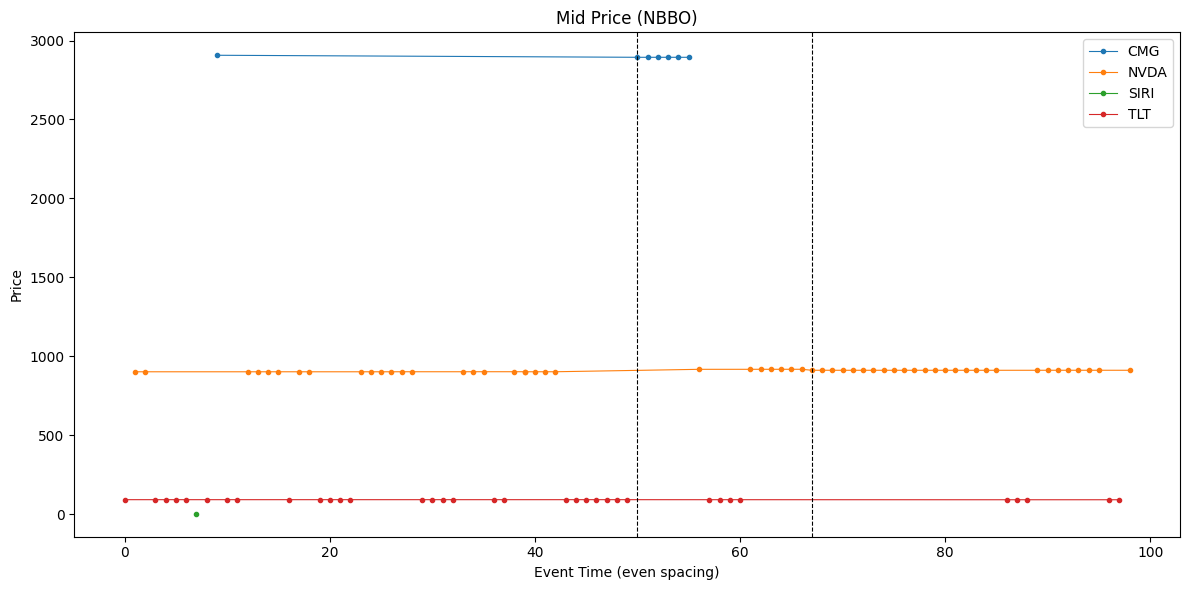

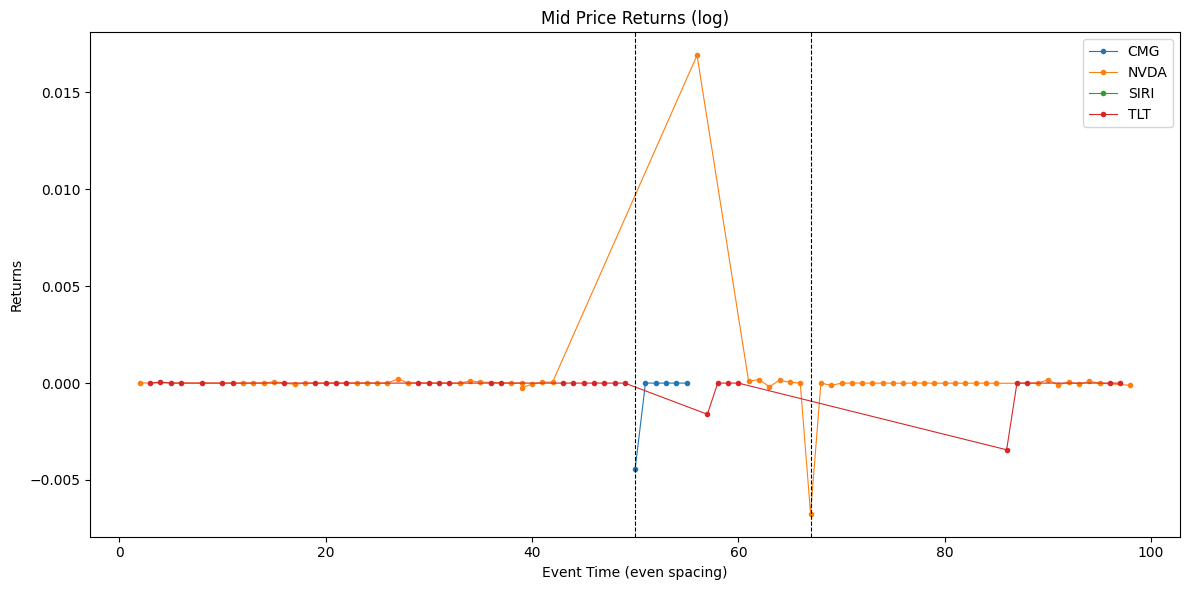

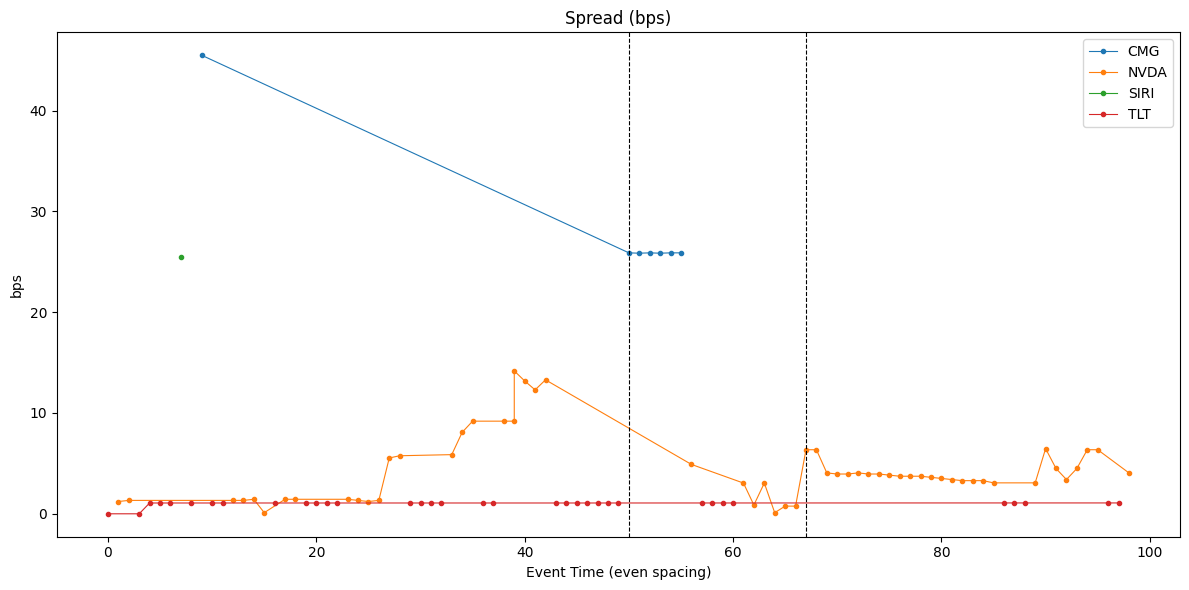

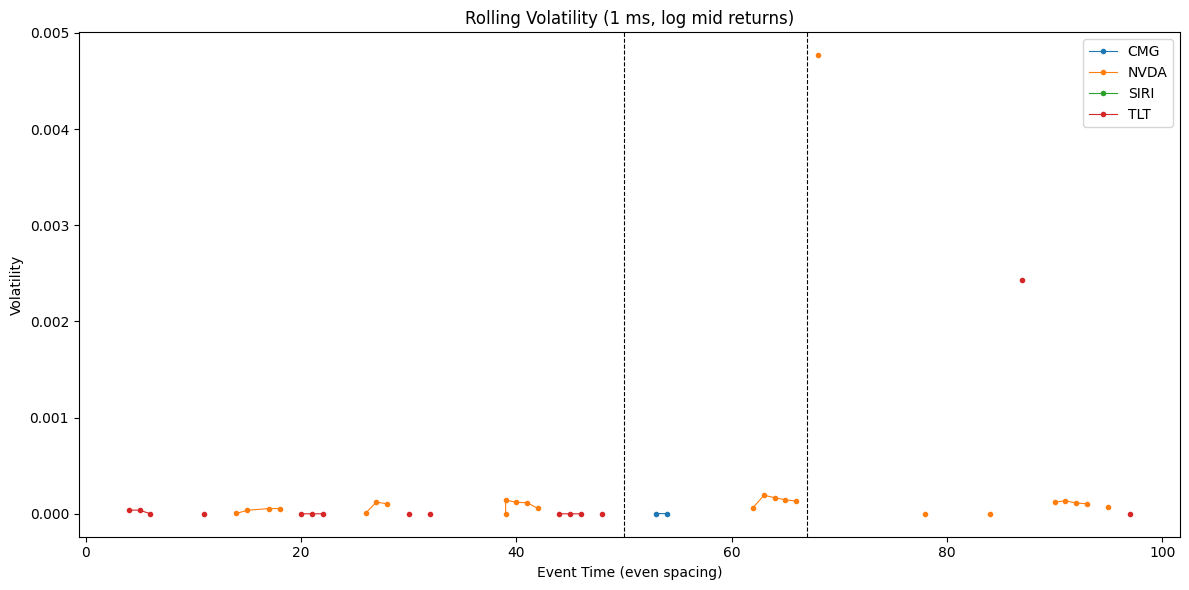

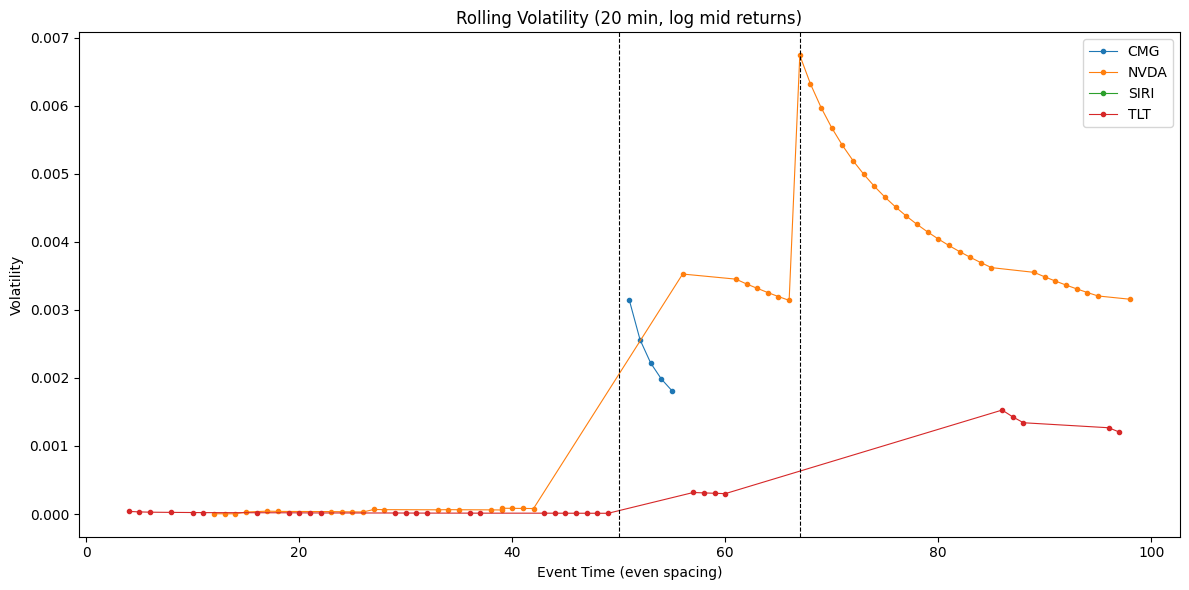

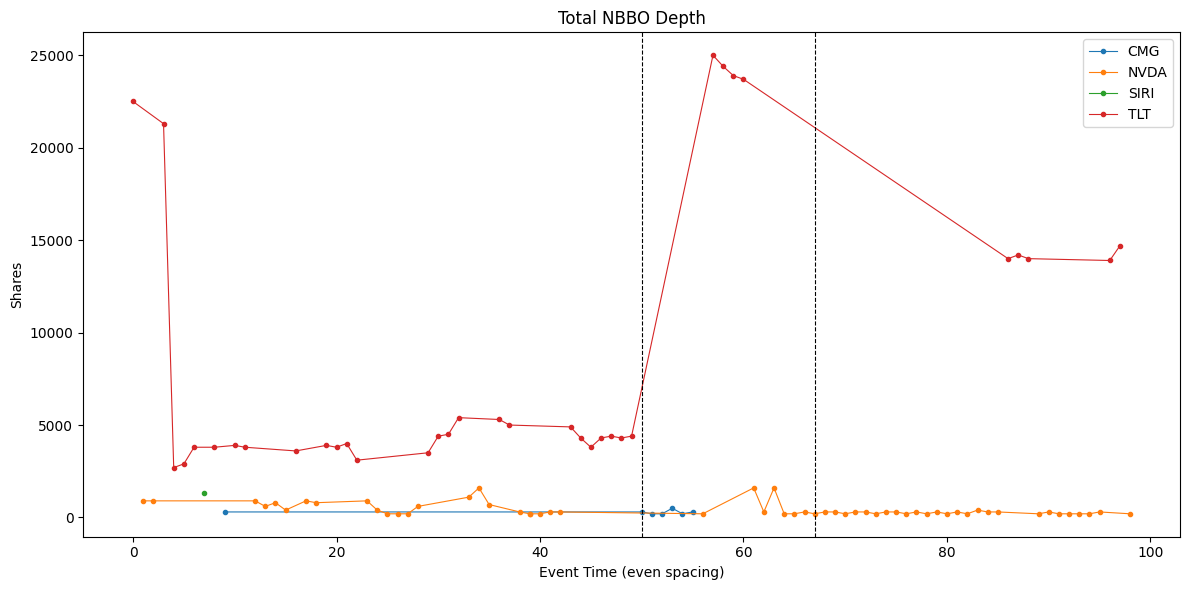

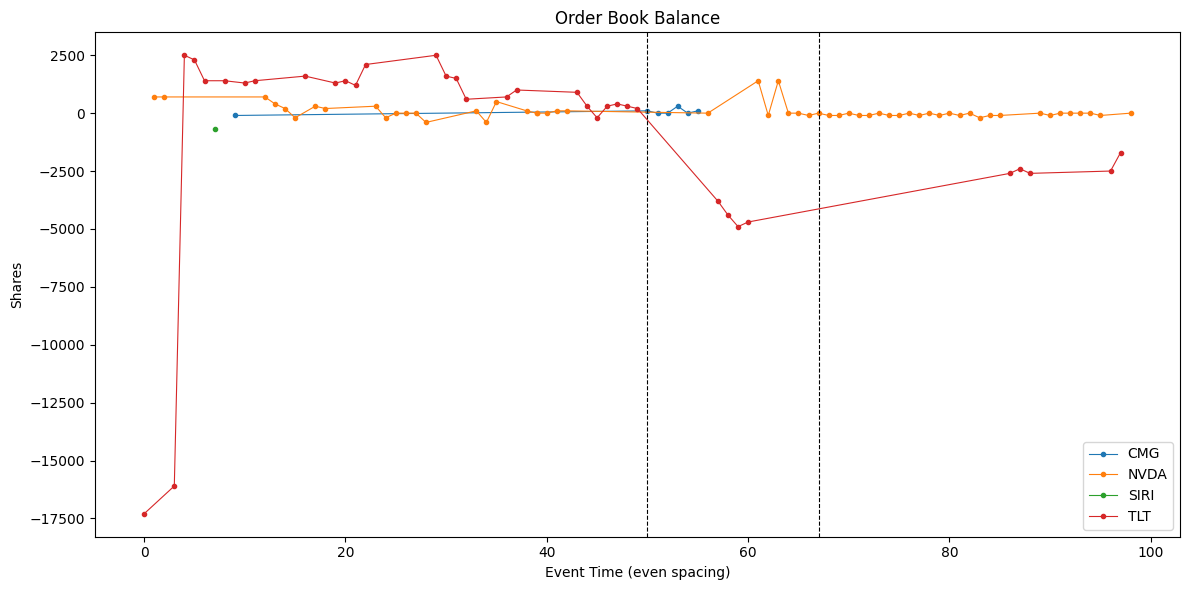

In [6]:
def find_gaps(timestamps, min_gap_minutes=5):
    ts = pd.Series(pd.to_datetime(timestamps)).sort_values().drop_duplicates().reset_index(drop=True)
    if ts.size < 2:
        return ts, []
    gaps = ts.diff().dropna()
    gap_indices = gaps[gaps >= pd.Timedelta(minutes=min_gap_minutes)].index.tolist()
    return ts, gap_indices

def plot_metric_event_axis(dfs, column, title, ylabel, ts, gap_indices):
    pos = pd.Series(range(len(ts)), index=ts)
    plt.figure(figsize=(12, 6))
    for symbol_name, sub in dfs.items():
        x = pos.loc[sub["transaction_timestamp"]].to_numpy()
        y = sub[column].to_numpy()
        plt.plot(
            x,
            y,
            label=symbol_name,
            linewidth=0.8,
            marker="o",
            markersize=3,
        )
    for idx in gap_indices:
        plt.axvline(idx, color="k", linestyle="--", linewidth=0.8)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel("Event Time (even spacing)")
    plt.legend()
    plt.tight_layout()
    plt.show()

all_ts = pd.concat([sub["transaction_timestamp"] for sub in quotes_by_symbol.values()])
ts, gap_indices = find_gaps(all_ts, min_gap_minutes=5)

plot_metric_event_axis(quotes_by_symbol, "mid_px", "Mid Price (NBBO)", "Price", ts, gap_indices)
plot_metric_event_axis(quotes_by_symbol, "mid_ret", "Mid Price Returns (log)", "Returns", ts, gap_indices)
plot_metric_event_axis(quotes_by_symbol, "spread_bps", "Spread (bps)", "bps", ts, gap_indices)
plot_metric_event_axis(quotes_by_symbol, "vol_1ms", "Rolling Volatility (1 ms, log mid returns)", "Volatility", ts, gap_indices)
plot_metric_event_axis(quotes_by_symbol, "vol_20min", "Rolling Volatility (20 min, log mid returns)", "Volatility", ts, gap_indices)
plot_metric_event_axis(quotes_by_symbol, "depth", "Total NBBO Depth", "Shares", ts, gap_indices)
plot_metric_event_axis(quotes_by_symbol, "balance", "Order Book Balance", "Shares", ts, gap_indices)


## Trade metrics

In [7]:
trades_by_symbol = {}
for symbol_id, symbol_name in symbol_map.items():
    if symbol_id not in trades["symbol_id"].unique():
        print(f"Symbol ID {symbol_id} not found in trades, skipping.")
        continue
    sub = trades[trades["symbol_id"] == symbol_id].copy()
    sub = sub.sort_values("transaction_timestamp")
    sub = sub.reset_index(drop=True)
    price_scaler = np.power(10.0, -trades["price_decimal"])
    sub["trade_px"] = sub["trade_price"] * price_scaler
    sub["log_ret"] = np.log(sub["trade_px"]).diff()
    sub = sub.set_index("transaction_timestamp")
    sub["vol_1s"] = sub["log_ret"].rolling("1s").std()
    sub = sub.reset_index()
    
    trades_by_symbol[symbol_name] = sub

# trades_by_symbol["NVDA"]

Symbol ID 9574 not found in trades, skipping.


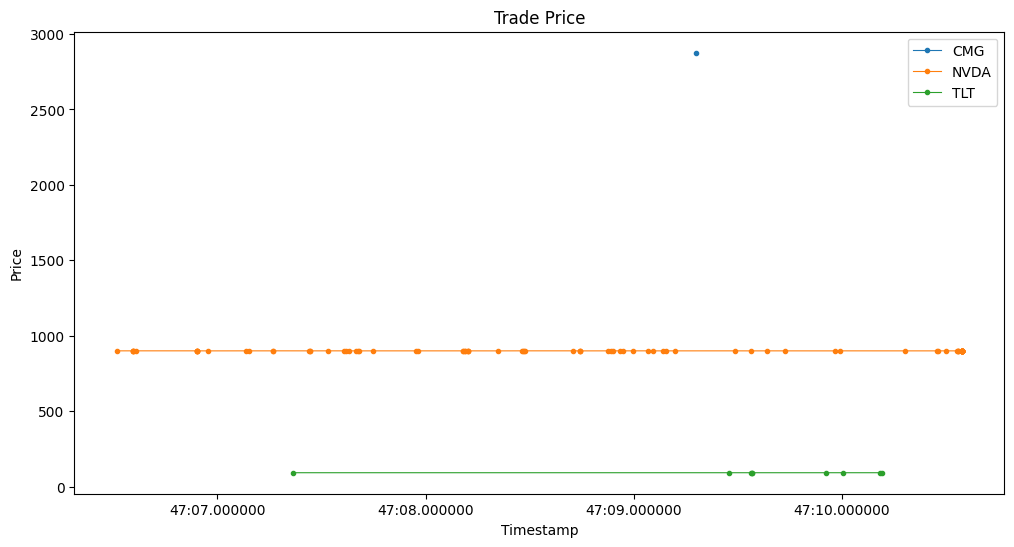

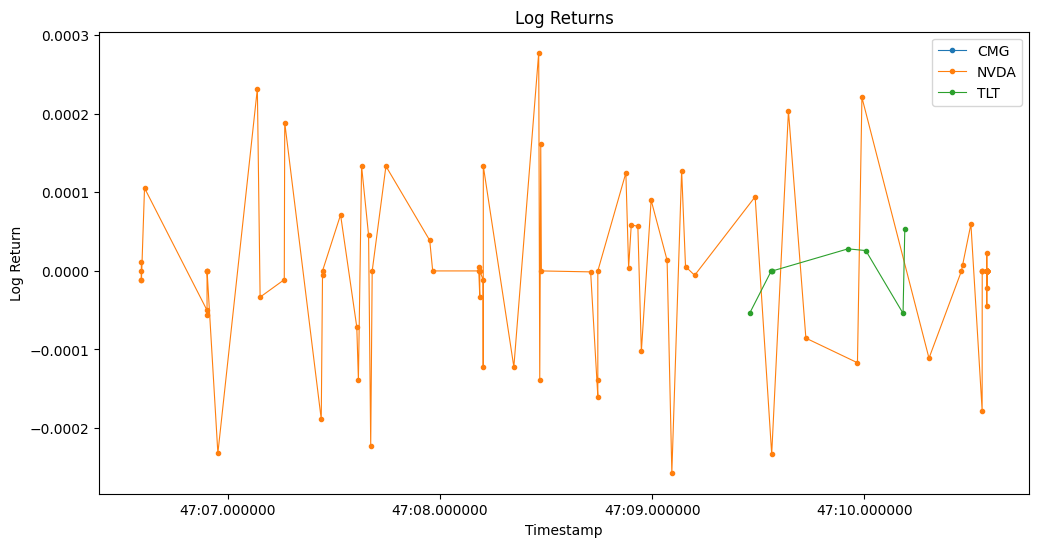

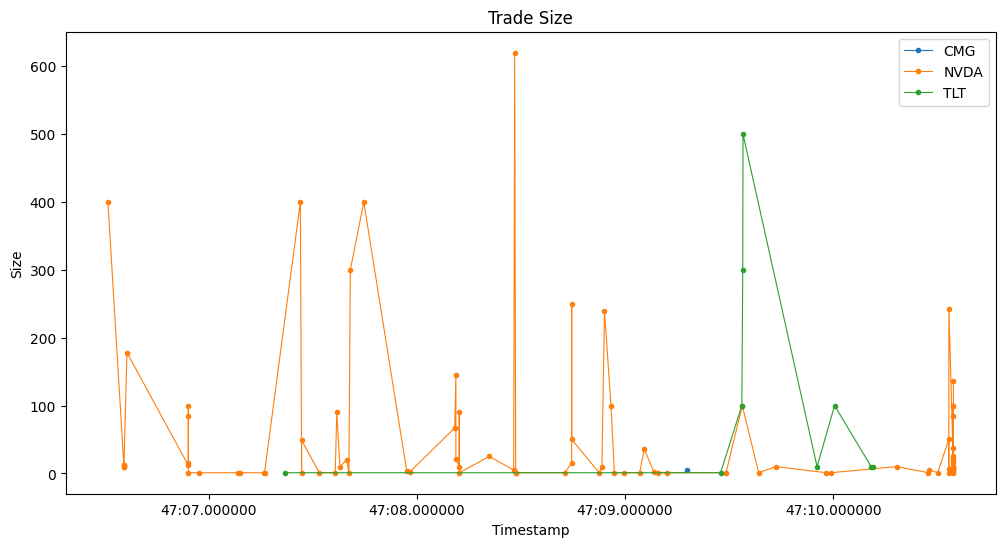

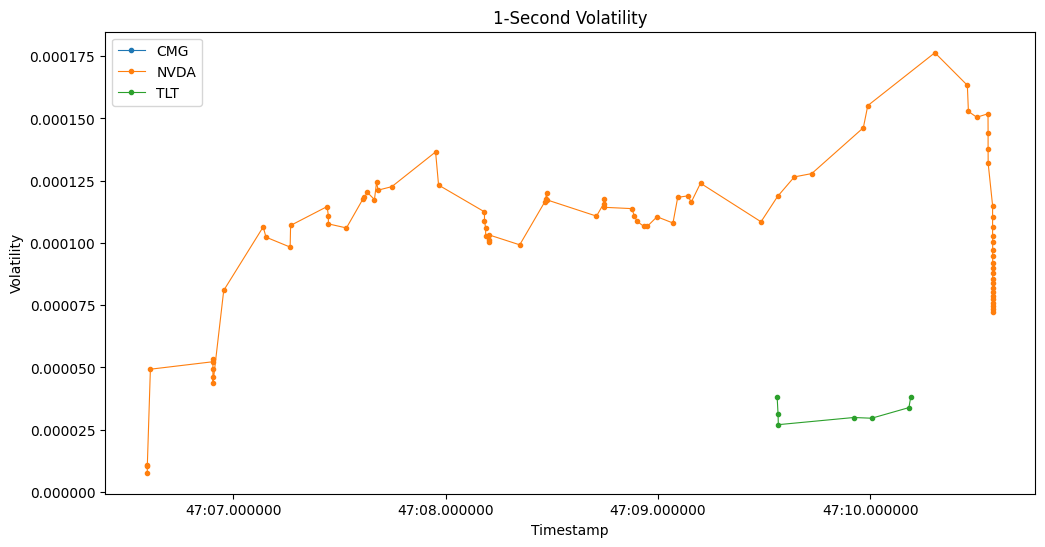

In [8]:
def plot_metric(dfs, column, title, ylabel):
    plt.figure(figsize=(12, 6))
    for symbol_name, df in dfs.items():
        plt.plot(
            df["transaction_timestamp"], 
            df[column], 
            label=symbol_name,
            linewidth=0.8,
            marker="o",
            markersize=3,
        )
    plt.title(title)
    plt.xlabel("Timestamp")
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

plot_metric(trades_by_symbol, "trade_px", "Trade Price", "Price")
plot_metric(trades_by_symbol, "log_ret", "Log Returns", "Log Return")
plot_metric(trades_by_symbol, "trade_size", "Trade Size", "Size")
plot_metric(trades_by_symbol, "vol_1s", "1-Second Volatility", "Volatility")

### Just NVDA

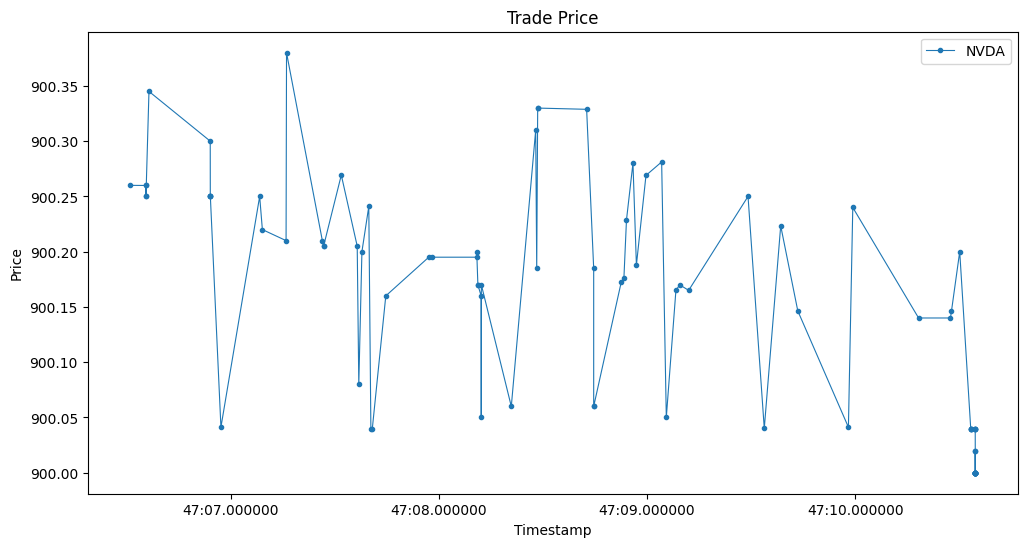

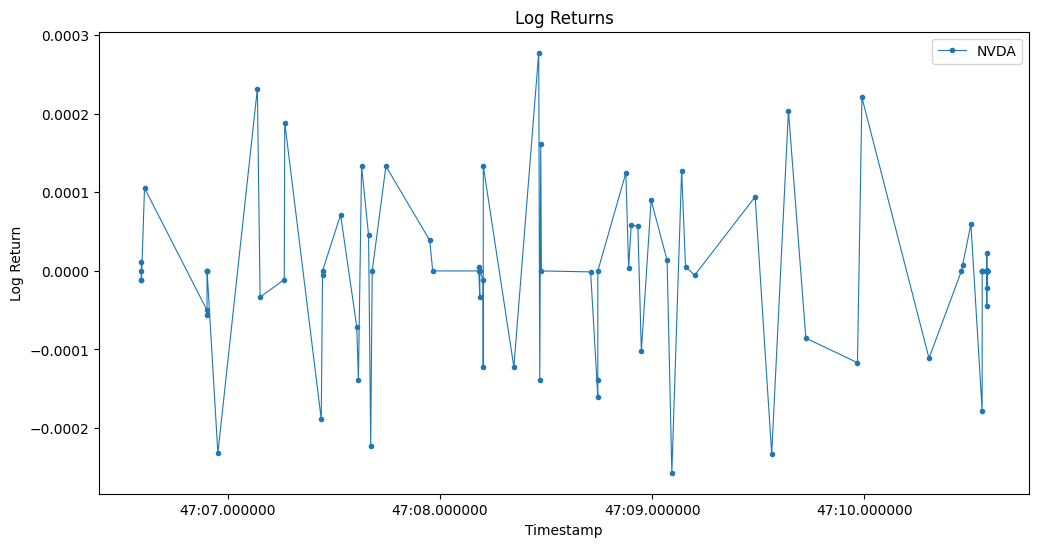

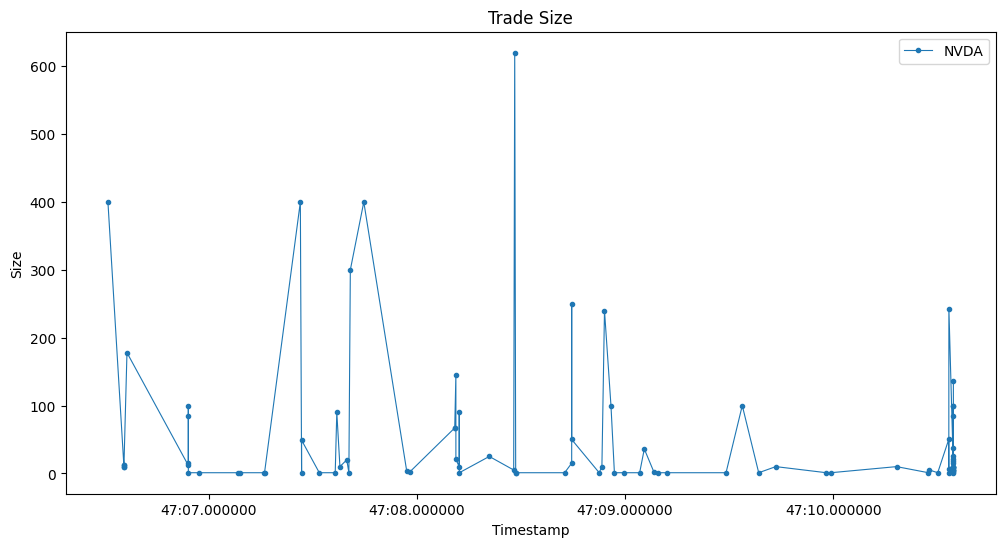

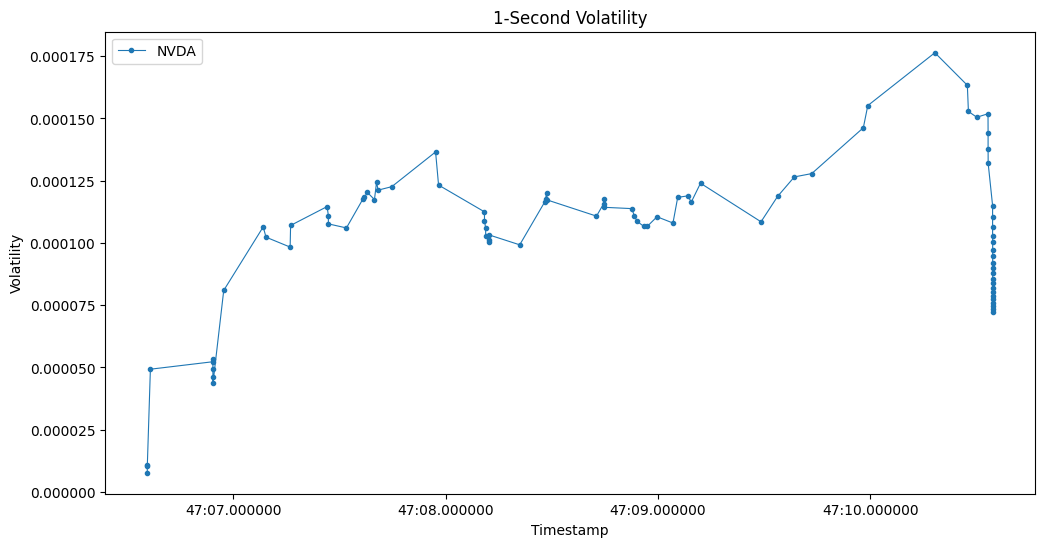

In [9]:
def plot_metric_one_ticker(df, column, title, ylabel, symbol_name):
    plt.figure(figsize=(12, 6))
    plt.plot(
        df["transaction_timestamp"], 
        df[column], 
        label=symbol_name,
        linewidth=0.8,
        marker="o",
        markersize=3,
    )
    plt.title(title)
    plt.xlabel("Timestamp")
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

plot_metric_one_ticker(trades_by_symbol["NVDA"], "trade_px", "Trade Price", "Price", "NVDA")
plot_metric_one_ticker(trades_by_symbol["NVDA"], "log_ret", "Log Returns", "Log Return", "NVDA")
plot_metric_one_ticker(trades_by_symbol["NVDA"], "trade_size", "Trade Size", "Size", "NVDA")
plot_metric_one_ticker(trades_by_symbol["NVDA"], "vol_1s", "1-Second Volatility", "Volatility", "NVDA")

### Trade size vs price

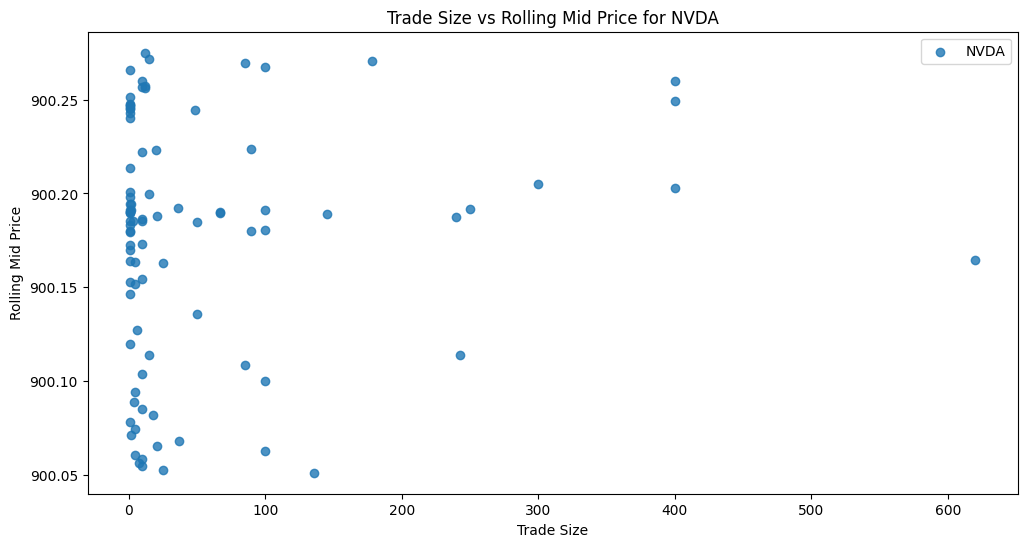

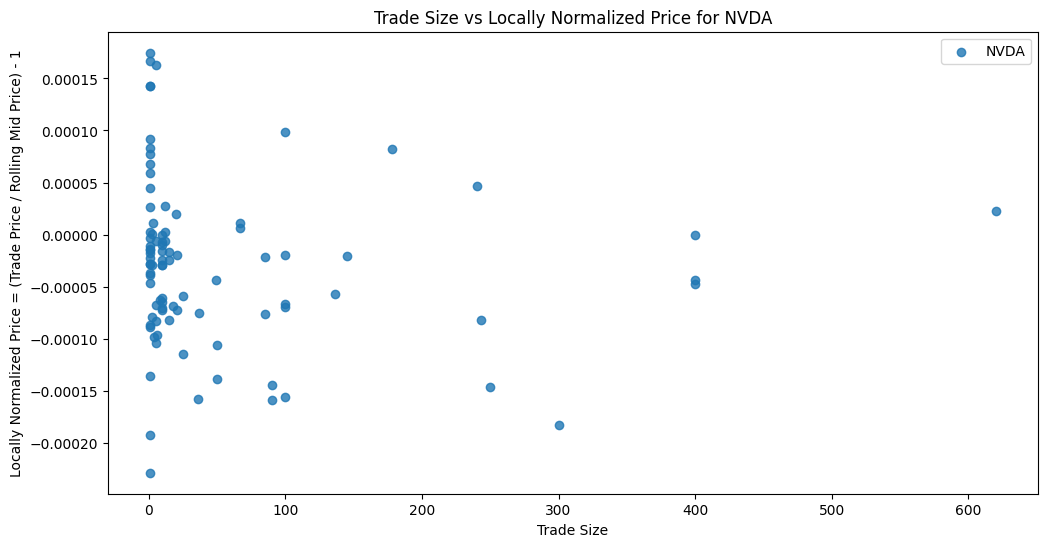

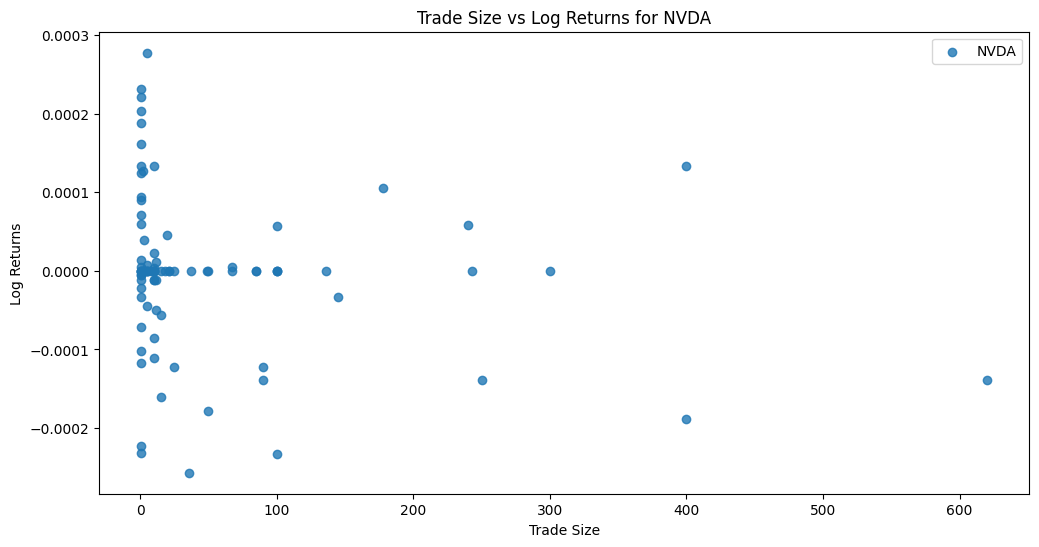

In [10]:
def plot_metric_scatter(df, x, y, symbol_name, title, xlabel, ylabel):
    plt.figure(figsize=(12, 6))
    plt.scatter(
        df[x],
        df[y],
        label=symbol_name,
        alpha=0.8
    )
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

nvda_df = trades_by_symbol["NVDA"].copy()
nvda_df = nvda_df.set_index("transaction_timestamp")
nvda_df["rolling_mid"] = nvda_df["trade_px"].rolling("1s").mean()
nvda_df = nvda_df.reset_index()
nvda_df["locally_normalized_px"] = nvda_df["trade_px"] / nvda_df["rolling_mid"] - 1

plot_metric_scatter(
    nvda_df,
    x="trade_size",
    y="rolling_mid",
    symbol_name="NVDA",
    title="Trade Size vs Rolling Mid Price for NVDA",
    xlabel="Trade Size",
    ylabel="Rolling Mid Price"
)

plot_metric_scatter(
    nvda_df,
    x="trade_size",
    y="locally_normalized_px",
    symbol_name="NVDA",
    title="Trade Size vs Locally Normalized Price for NVDA",
    xlabel="Trade Size",
    ylabel="Locally Normalized Price = (Trade Price / Rolling Mid Price) - 1"
)

plot_metric_scatter(
    nvda_df,
    x="trade_size",
    y="log_ret",
    symbol_name="NVDA",
    title="Trade Size vs Log Returns for NVDA",
    xlabel="Trade Size",
    ylabel="Log Returns"
)